# Workload Analysis

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
system_num_nodes = 1490

d_const = 0.03
r_const = 0.02
system_mtbf_hours = 13 * 24
node_mtbf_hours_baseline = system_mtbf_hours * system_num_nodes

times_worse = [1, 2, 4, 8, 16, 32]

app_eff_factor = 0.1

In [4]:
print(f"node MTBF hours baseline = {node_mtbf_hours_baseline}")

node MTBF hours baseline = 464880


In [5]:
wls = ['wl1.csv', 'wl2.csv', 'wl3.csv', 'wl4.csv', 'wl5.csv', 'wl6.csv']
size_craig_used = {
    'wl1.csv' : 100000,
    'wl2.csv' : 30000,
    'wl3.csv' : 5000,
    'wl4.csv' : 3000,
    'wl5.csv' : 500,
    'wl6.csv' : 500
}

compare_to_craig = True

In [6]:
# read all the workloads in
dfs = {}
for wl in wls:
    if compare_to_craig:
        dfs[wl] = pd.read_csv(wl, header=None, names=['num_nodes','dur'], nrows = size_craig_used[wl])
    else:
        dfs[wl] = pd.read_csv(wl, header=None, names=['num_nodes','dur'])
  

In [7]:
for wl in wls:
    df = dfs[wl]
    df['dumptime'] = d_const * df['dur']
    df['readtime'] = r_const * df['dur']
    df['M_baseline'] = node_mtbf_hours_baseline / df['num_nodes']
    df['tc_baseline'] = np.sqrt(2 * df['dumptime'] * df['M_baseline']) # only true if `dumptime < 1/2 M`
    df['AppEff_baseline'] = np.exp(-df['readtime'] / df['M_baseline']) * \
        ( (df['tc_baseline'] / df['M_baseline'] - df['dumptime'] / df['M_baseline']) / \
         (np.exp(df['tc_baseline'] / df['M_baseline']) - 1) ) # only true if `dumptime << dur`
    df['TsiNi'] = df['dur'] * df['num_nodes']
    
    df['application_efficiency_valid'] = df['dumptime'] < (df['dur'] * app_eff_factor)

    for worse in times_worse:
        df[f'M_{worse}'] = (node_mtbf_hours_baseline / worse) / df['num_nodes']
        df[f'tc_{worse}'] = np.sqrt(2 * df['dumptime'] * df[f'M_{worse}']) # only true if `dumptime < 1/2 M`
        df[f'AppEff_{worse}'] = np.exp(-df['readtime'] / df[f'M_{worse}']) * \
            ( (df[f'tc_{worse}'] / df[f'M_{worse}'] - df['dumptime'] / df[f'M_{worse}']) / \
             (np.exp(df[f'tc_{worse}'] / df[f'M_{worse}']) - 1) ) # only true if `dumptime << dur`
        df[f'TriNi_{worse}'] = (df['dur'] / df[f'AppEff_{worse}']) * df['num_nodes']
        
        df[f'checkpoint_less_than_dur_{worse}'] = df[f'tc_{worse}'] < df['dur']
        
        df[f'checkpoint_interval_valid_{worse}'] = df['dumptime'] < (0.5 * df[f'M_{worse}'])


In [8]:
results = pd.DataFrame()

for wl in wls:
    print(f"Workload: {wl}")
    df = dfs[wl]
    
    # calculate average app efficiency - not just .mean
    baseline = df['TsiNi'].sum() / df[f'TriNi_1'].sum()
    for worse in times_worse:
        i = df['TsiNi'].sum() / df[f'TriNi_{worse}'].sum()
        ratio = (1/i) / (1/baseline) 
        print(f"{worse:2d}x -> avg App Eff = {i:.4f}, \
y_intercept = {ratio:.4f}, \
% ckpted = {(100.0 * (df[f'checkpoint_less_than_dur_{worse}'].sum() / df[f'checkpoint_less_than_dur_{worse}'].count())):.2f}%, \
% app eff valid = {(100.0 * (df['application_efficiency_valid'].sum() / df['application_efficiency_valid'].count())):.2f} \
% ckpt interval valid = {(100.0 * (df[f'checkpoint_interval_valid_{worse}'].sum() / df[f'checkpoint_interval_valid_{worse}'].count())):.2f}\
")

        results = results.append({'workload': (wl.replace('.csv','')).upper(),
                                  'xWorse': f"{worse:.0f}x",
                                  'appEff': i,
                                  'y_intercept': ratio
                                 },
                                 ignore_index=True)

    print()
    


Workload: wl1.csv
 1x -> avg App Eff = 0.9982, y_intercept = 1.0000, % ckpted = 0.00%, % app eff valid = 100.00 % ckpt interval valid = 100.00
 2x -> avg App Eff = 0.9975, y_intercept = 1.0007, % ckpted = 0.00%, % app eff valid = 100.00 % ckpt interval valid = 100.00
 4x -> avg App Eff = 0.9965, y_intercept = 1.0018, % ckpted = 0.00%, % app eff valid = 100.00 % ckpt interval valid = 100.00
 8x -> avg App Eff = 0.9950, y_intercept = 1.0032, % ckpted = 0.00%, % app eff valid = 100.00 % ckpt interval valid = 100.00
16x -> avg App Eff = 0.9930, y_intercept = 1.0053, % ckpted = 0.00%, % app eff valid = 100.00 % ckpt interval valid = 100.00
32x -> avg App Eff = 0.9900, y_intercept = 1.0083, % ckpted = 0.00%, % app eff valid = 100.00 % ckpt interval valid = 100.00

Workload: wl2.csv
 1x -> avg App Eff = 0.9843, y_intercept = 1.0000, % ckpted = 0.00%, % app eff valid = 100.00 % ckpt interval valid = 100.00
 2x -> avg App Eff = 0.9776, y_intercept = 1.0068, % ckpted = 0.03%, % app eff valid = 1

In [9]:
# remove the baseline from the results
results = results.query("xWorse != '1x'")

In [10]:
# read in the spreadsheet from Google Drive

input_tsv = "data.tsv"
df = pd.read_csv(input_tsv, sep='\t', skiprows=3, header=None)
cols = [0,22,23]
df.drop(df.columns[cols],axis=1,inplace=True)
t = df.T
cols = [9,10,11,12,22,23,24,25,26,27,28]
t.drop(t.columns[cols],axis=1,inplace=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [12]:
df_non_scaled = t.iloc[:,:9]
df_scaled = t.iloc[:,9:18]

new_header = df_non_scaled.iloc[0] #grab the first row for the header
df_non_scaled = df_non_scaled[1:] #take the data less the header row
df_non_scaled.columns = new_header #set the header row as the df header

new_header = df_scaled.iloc[0] #grab the first row for the header
df_scaled = df_scaled[1:] #take the data less the header row
df_scaled.columns = new_header #set the header row as the df header

df_non_scaled = df_non_scaled.melt(value_vars={"WL1","WL2","WL3","WL4","WL5","WL6"}, value_name='value', id_vars = {"baseline MTBF (day)", "xWorse", "X_or_Y"}, var_name='WL')
df_non_scaled['value'] = df_non_scaled['value'].str.replace("*","", regex=True)
df_non_scaled['value'] = pd.to_numeric(df_non_scaled['value'])
df_non_scaled['WL'] = pd.Categorical(df_non_scaled['WL'], categories=["WL1","WL2","WL3","WL4","WL5","WL6"])
df_non_scaled['X_or_Y'] = pd.Categorical(df_non_scaled['X_or_Y'], categories=['Y','X'])

df_scaled = df_scaled.melt(value_vars={"WL1","WL2","WL3","WL4","WL5","WL6"}, value_name='value', id_vars = {"baseline MTBF (day)", "xWorse", "X_or_Y"}, var_name='WL')
df_scaled['value'] = df_scaled['value'].str.replace("*","", regex=True)
df_scaled['value'] = pd.to_numeric(df_scaled['value'])
df_scaled['WL'] = pd.Categorical(df_scaled['WL'], categories=["WL1","WL2","WL3","WL4","WL5","WL6"])
df_scaled['X_or_Y'] = pd.Categorical(df_scaled['X_or_Y'], categories=['Y','X'])

In [13]:
df_scaled_13 = df_scaled[df_scaled['baseline MTBF (day)'] == '13']
df_scaled_13 = df_scaled_13[df_scaled_13['X_or_Y'] == 'Y']
df_scaled_13.drop(columns = ["X_or_Y", "baseline MTBF (day)"], inplace = True)

In [14]:
results.head()

appEff workload xWorse  y_intercept
1  0.997511      WL1     2x     1.000731
2  0.996480      WL1     4x     1.001766
3  0.995022      WL1     8x     1.003234
4  0.992960      WL1    16x     1.005317
5  0.990044      WL1    32x     1.008278

In [18]:
df_scaled_13.head()

xWorse   WL  value
11     2x  WL5   1.01
13     4x  WL5   1.05
15     8x  WL5   1.09
17    16x  WL5   1.16
19    32x  WL5   1.28

In [19]:
df_merged = pd.merge(results, df_scaled_13, left_on=["workload","xWorse"], right_on=["WL","xWorse"], how='left')
df_merged.drop(columns = ['WL', 'appEff'], inplace=True)
df_merged.head()

workload xWorse  y_intercept  value
0      WL1     2x     1.000731    1.0
1      WL1     4x     1.001766    1.0
2      WL1     8x     1.003234    1.0
3      WL1    16x     1.005317    1.0
4      WL1    32x     1.008278    1.0

In [20]:
df_merged.rename({'value' : 'simulation'}, axis = 'columns', inplace = True)
df_merged.rename({'y_intercept' : 'analytical model'}, axis = 'columns', inplace = True)
df_merged = df_merged.melt(id_vars = {'workload','xWorse'})

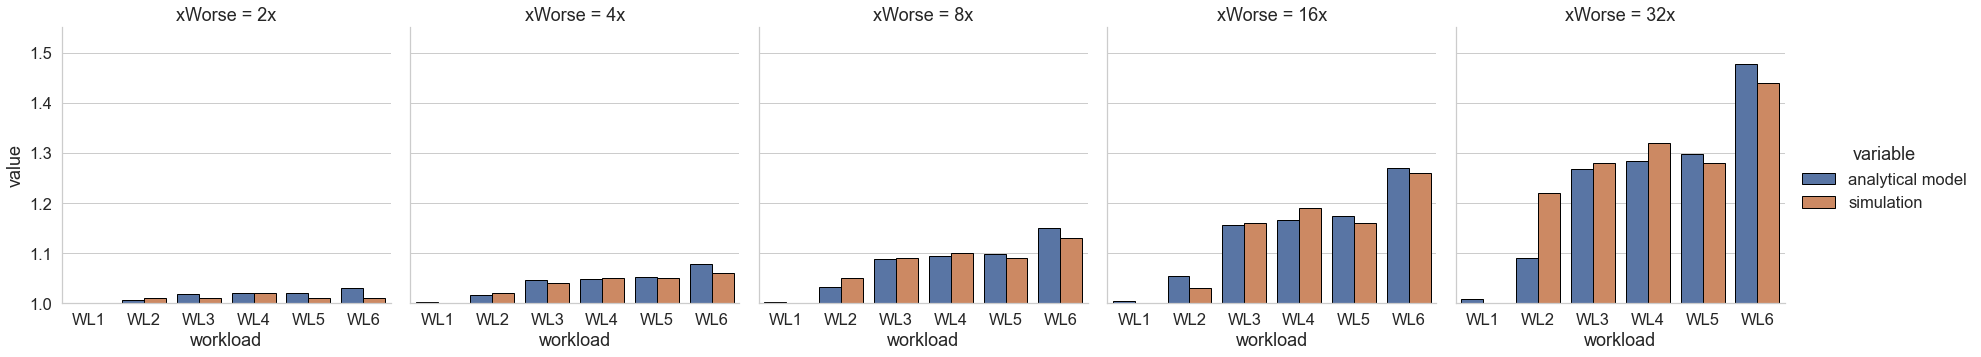

In [21]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.catplot(x='workload', y='value', hue='variable', col='xWorse', 
                data=df_merged, 
                kind='bar',
                lw=1,
                edgecolor='black')
g.set(ylim=(1.0,None))

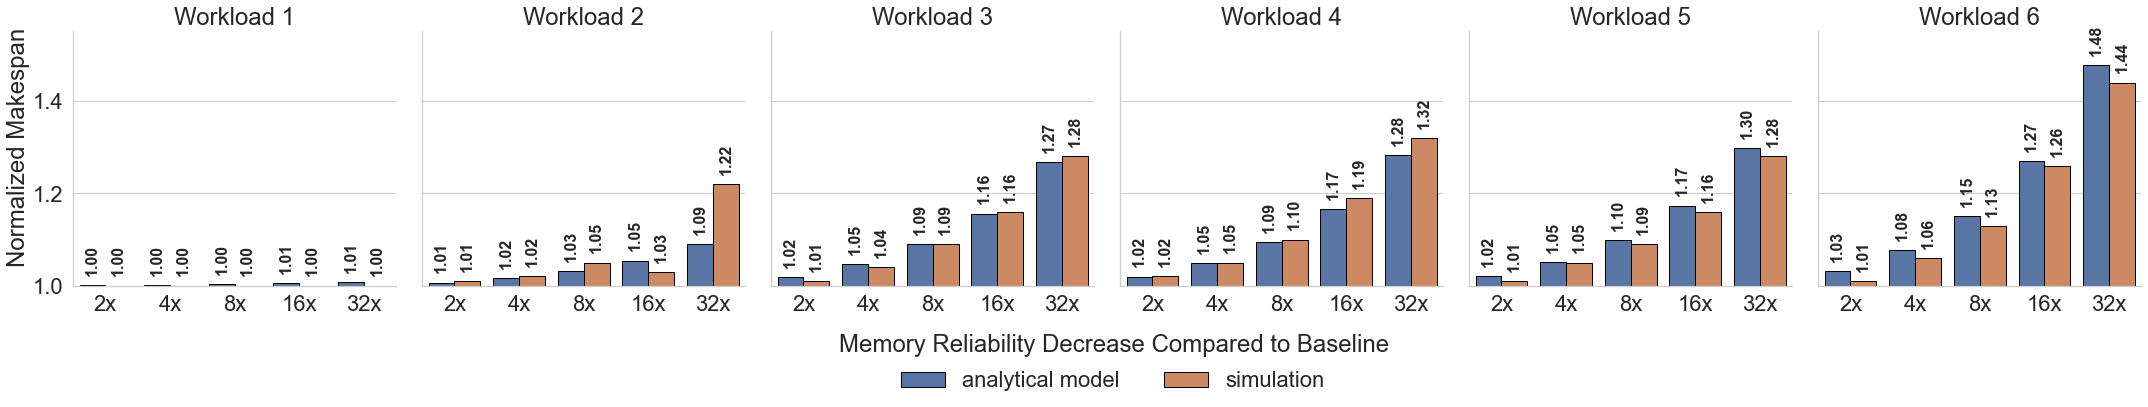

In [22]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
g = sns.catplot(x='xWorse', y='value', hue='variable', col='workload', 
                data=df_merged, 
                kind='bar',
                lw=1,
                edgecolor='black', legend_out=True, legend=False)
g.set(ylim=(1.0,None))
plt.legend(bbox_to_anchor=(-1.50, -0.30),
           borderaxespad=0, 
           frameon=False, 
           ncol=2)

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 25), 
                    textcoords = 'offset points', 
                    fontsize=16, 
                    fontweight='bold', 
                    rotation=90)

axes = g.axes.flatten()
axes[0].set_title("Workload 1")
axes[1].set_title("Workload 2")
axes[2].set_title("Workload 3")
axes[3].set_title("Workload 4")
axes[4].set_title("Workload 5")
axes[5].set_title("Workload 6")

g.set(ylabel = None)
g.set(xlabel = None)
g.fig.text(0, 0.22, "Normalized Makespan", rotation=90)
g.fig.text(0.385, -0.03, "Memory Reliability Decrease Compared to Baseline")
g.savefig("bars-scaled-13MTBF-y-anal-vs-sim.pdf")
#plt.legend(loc='upper left')